# Use super-resolution to retrieve high-resolution salinity - Data description 

In [3]:
import earthaccess
import pylab as plt 
import xarray as xr
import requests

In [4]:
earthaccess.login()
results = earthaccess.search_data(
    short_name='MITgcm_LLC4320_Pre-SWOT_JPL_L4_CapeBasin_v1.0',
    count=1000
)

Granules found: 429


In [6]:
files = earthaccess.download(results[:1], "./local_folder")

 Getting 1 granules, approx download size: 1.44 GB
Accessing cloud dataset using dataset endpoint credentials: https://archive.podaac.earthdata.nasa.gov/s3credentials
Downloaded: local_folder/LLC4320_pre-SWOT_CapeBasin_20110913.nc


In [7]:
data=xr.open_dataset('local_folder/LLC4320_pre-SWOT_CapeBasin_20110913.nc')
display(data)

<xarray.Dataset> Size: 4GB
Dimensions:   (j_g: 282, i: 192, i_g: 192, j: 282, k: 88, k_u: 88, k_l: 88,
               k_p1: 89, nb: 2, time: 24)
Coordinates:
  * j_g       (j_g) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 278.0 279.0 280.0 281.0
  * i         (i) float32 768B 0.0 1.0 2.0 3.0 4.0 ... 188.0 189.0 190.0 191.0
  * i_g       (i_g) float32 768B 0.0 1.0 2.0 3.0 4.0 ... 188.0 189.0 190.0 191.0
  * j         (j) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 278.0 279.0 280.0 281.0
  * k         (k) int32 352B 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87
  * k_u       (k_u) int32 352B 0 1 2 3 4 5 6 7 8 ... 79 80 81 82 83 84 85 86 87
  * k_l       (k_l) int32 352B 0 1 2 3 4 5 6 7 8 ... 79 80 81 82 83 84 85 86 87
  * k_p1      (k_p1) int32 356B 0 1 2 3 4 5 6 7 8 ... 80 81 82 83 84 85 86 87 88
  * nb        (nb) int32 8B 0 1
  * time      (time) datetime64[ns] 192B 2011-09-13 ... 2011-09-13T23:00:00
Data variables: (12/33)
    XC        (j, i) float32 217kB ...
    YC        (j, i) float32 217kB ...
    DXV       (j, i) float32 217kB ...
    DYU       (j, i) float32 217kB ...
    Depth     (j, i) float32 217kB ...
    DXC       (j, i_g) float32 217kB ...
    ...        ...
    oceTAUY   (time, j_g, i) float64 10MB ...
    Theta     (time, k, j, i) float64 915MB ...
    Salt      (time, k, j, i) float64 915MB ...
    U         (time, k, j, i_g) float32 457MB ...
    V         (time, k, j_g, i) float64 915MB ...
    W         (time, k_l, j, i) float64 915MB ...
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2011-09-13 23:00:00
    time_coverage_start:             2011-09-13 00:00:00
    title:                           LLC4320 regional Cape Basin
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

## Origional high-resolution sea surface fields 

Text(0, 0.5, '/cycle/km')

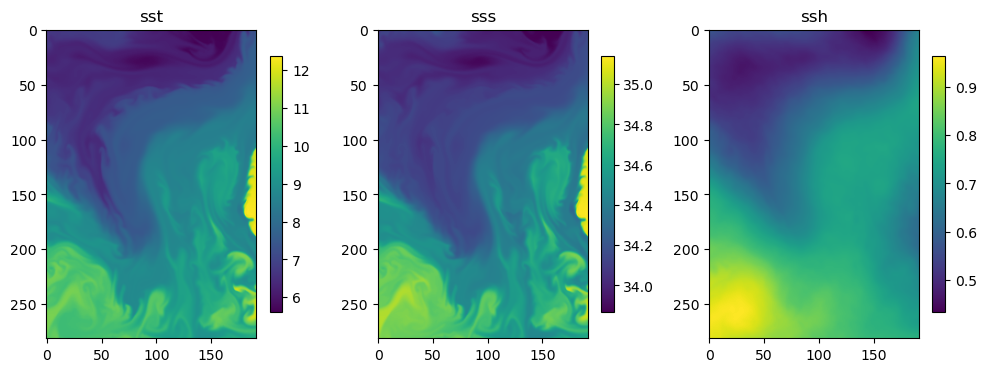

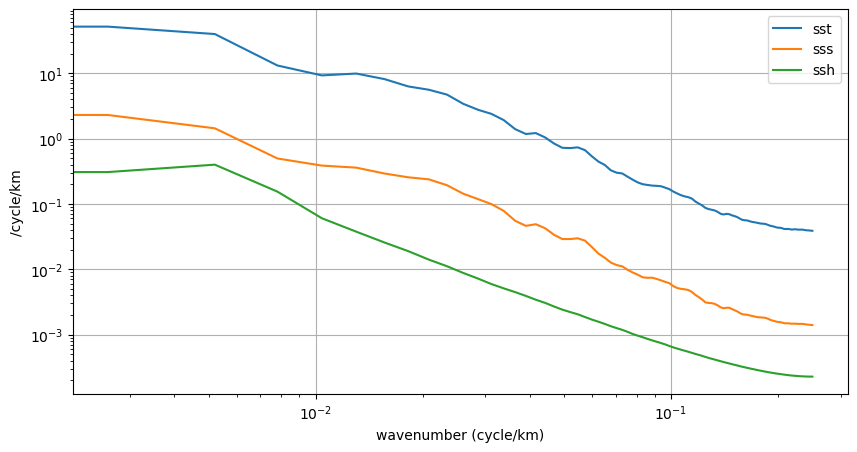

In [33]:
fig,axs=plt.subplots(1,3,figsize=(10,4)) 

def spectrum(data, dx=2): 
    from scipy.signal import welch 
    nj,ni=data.shape
    f,a=welch(data.flatten(),nfft=ni, nperseg=ni,
              window='hann',fs=1/dx,detrend='linear')
    a[-1]*=2
    return f,a

datain={}
datain['sst']=data['Theta'][0,0,...]
datain['sss']=data['Salt'][0,0,...]
datain['ssh']=data['Eta'][0,...]

for ax, var in zip(axs,datain.keys()): 
    cb=ax.imshow(datain[var].data)
    plt.colorbar(cb,shrink=0.7)
    ax.set_title(var)

plt.tight_layout()

plt.figure(figsize=(10,5))
for var in datain.keys():
    f,a=spectrum(datain[var].data)
    plt.loglog(f,a,label=var)
plt.legend()
plt.grid(True)
plt.xlabel('wavenumber (cycle/km)')
plt.ylabel('/cycle/km')

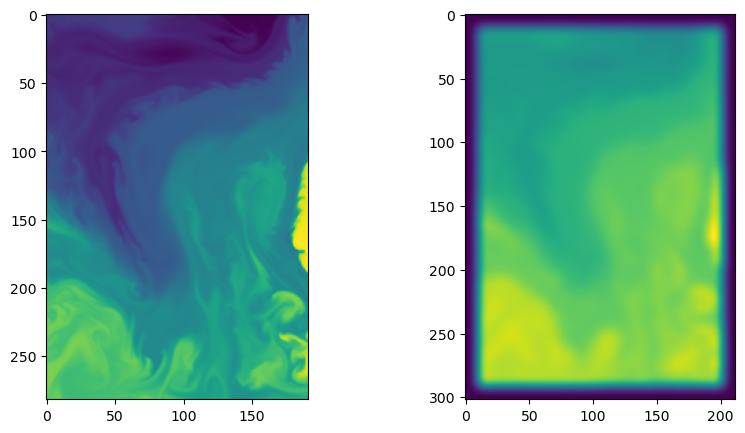

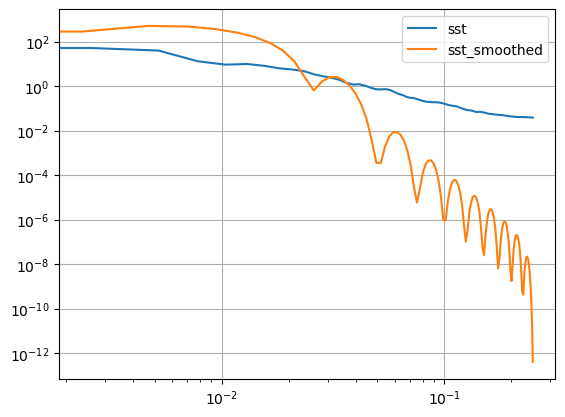

In [66]:
from scipy import signal 
import numpy as np

w1d = np.abs(np.hanning(21))
w2d = w1d.reshape(21,1)*w1d.reshape(1,21)
w2d/=w2d.sum()

sst_smoothed=signal.convolve2d(datain['sst'].data, w2d, mode='full', boundary='fill', fillvalue=0)

fig,ax=plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(datain['sst'].data)
ax[1].imshow(sst_smoothed)

plt.figure()
f,a=spectrum(datain['sst'].data)
plt.loglog(f,a,label='sst')
f,a=spectrum(sst_smoothed)
plt.loglog(f,a,label='sst_smoothed')

plt.legend()
plt.grid(True)

## Smoothed version